<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_13/s13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Connect Google Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/', force_remount=True)

Install packages

In [6]:
#!git clone "https://github.com/jyanivaddi/ERA_V1.git"
#!git -C ERA_V1 pull
#!cd ../
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git -C dl_hub pull
!git pull
#!cd ../

!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torchsummary"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"
!pip install --quiet "gradio"

fatal: destination path 'dl_hub' already exists and is not an empty directory.
Already up to date.
Already up to date.

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import sys
sys.path.append("ERA_V1/session_13")
sys.path.append("dl_hub")

In [8]:
!git -C dl_hub pull


Already up to date.


In [11]:
import dl_hub.YOLO_V3.config as config
import torch
import torch.optim as optim
import os
from dl_hub.YOLO_V3.model import YOLOv3
from tqdm import tqdm
from dl_hub.YOLO_V3.yolo_v3_utils.utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from dl_hub.YOLO_V3.yolo_v3_utils.loss import YoloLoss
from dl_hub.YOLO_V3.PL_model import LitYOLOv3
from dl_hub.YOLO_V3.yolo_v3_utils.PL_data_module import YOLODataModule
from dl_hub.PL_main import train_and_eval_pl_model
import warnings
warnings.filterwarnings("ignore")

In [10]:
print(config.DATASET)


/home/e183534/PASCAL_VOC


**Define Data Module**

In [16]:
# Define data module
#csv_files = [os.path.join(config.DATASET, "100examples.csv"),os.path.join(config.DATASET,"8examples.csv")]
csv_files = [os.path.join(config.DATASET, "train.csv"),os.path.join(config.DATASET,"test.csv")]
train_transforms=config.train_transforms
test_transforms=config.test_transforms
val_transforms = test_transforms
IMAGE_SIZE = config.IMAGE_SIZE
S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
img_dir=config.IMG_DIR
label_dir=config.LABEL_DIR
anchors=config.ANCHORS
batch_size = 8
yolo_dm = YOLODataModule(
    csv_files,
    img_dir,
    label_dir,
    anchors,
    batch_size,
    image_size=IMAGE_SIZE,
    S=S,
    C=20,
    train_transforms = train_transforms,
    val_transforms = val_transforms,
    test_transforms = test_transforms,
    val_split=0.1,
    num_workers = config.NUM_WORKERS,
    use_mosaic_on_train=True,
    mosaic_probability=0.75,
    pin_memory = False)
yolo_dm.prepare_data()
yolo_dm.setup()

**Identify best LR**

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.87E-02


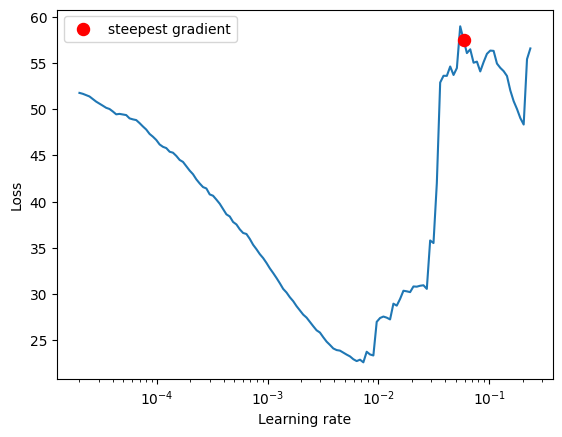

In [13]:
from torch_lr_finder import LRFinder

# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_fn = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
EPOCHS = config.NUM_EPOCHS * 2 // 5

# Define Model
dummy_yolo_model = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(dummy_yolo_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
train_data_loader = yolo_dm.train_dataloader()

def criterion(out, y):
    y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss
lr_finder = LRFinder(dummy_yolo_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_data_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
max_lr = 8E-4

Resume Training

In [17]:
from torch.optim.lr_scheduler import OneCycleLR
# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_criterion = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
# Define Model
yolo_model = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(yolo_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
train_data_loader = yolo_dm.train_dataloader()
EPOCHS = config.NUM_EPOCHS * 2 // 5
scheduler = OneCycleLR(
        optimizer,
        max_lr=1E-3,
        steps_per_epoch=len(train_data_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )
yolo_model = LitYOLOv3(loss_criterion, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=20)
yolo_model.set_optimizer(optimizer)
yolo_model.set_scheduler_dict(scheduler,freq='step')

# resume trainingdd
#ckpt_path = "/kaggle/working/logs/checkpoint_epoch_5_step_72.ckpt"
#trainer = train_pl_model(yolo_model, yolo_dm, epochs = EPOCHS)